In [2]:
import zipfile
import os
from pathlib import Path
from datetime import datetime
import pandas as pd
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import numpy as np

# I have fund data in a zip folder. I will be processing the files and providing Exploratory Data Analysis

#### Zip folder has multiple folders for data recorded at different timestamp. Within each folder, there is three files,
- TIMESTEMP.txt (Contains timestemp information for the data) 
- ROR.csv (Contains RoR information for multiple funds by months from 1959 to 2019) (726894 rows and 4 columns)
- Assets.csv (Contains assets information for multiple fundsby months from 1959 to 2019) (467510 rows and 3 columns)

## Unzip the funds data

In [3]:
def unzip_files(PATH): # Function requires path to zip folder as a argument
    with zipfile.ZipFile(PATH, 'r') as zip_file:
        # Function will create Unzipped folder within working directory and extract all files in Unzipped folder
        zip_file.extractall('Unzipped') 

In [4]:
# Assuming zip folder is in same directory as of this notebook, if not then need to pass correct path
unzip_files("HF Archives.zip") 

## Process the unzipped folder and load latest Data

#### Find the latest fund data and only load the latest Data for EDA.

In [5]:

# recursively iterate through the unzipped folder and record all timestamps and its parent folder path
pathlist = Path("Unzipped").glob('**/*')
Times= []
for path in pathlist:
     if os.path.splitext(path)[1] == '.txt':
         with open(path , 'r') as f:
             time =  f.read()
             Times.append((str(path.parents[0]) , datetime.strptime(time, "%Y%m%d")))

# return latest timestamps and latest funds directory path
funds_timstamp = [x[1] for x in Times]
latest_timestamp = max(funds_timstamp)
latest_timestamp_index = funds_timstamp.index(latest_timestamp)
latest_funds_parent_path = Times[latest_timestamp_index][0]

# Loop through all the csv files in latest funds directory and load the data
dataframs = []
dataframe_names= []
latest_fund_data = Path(latest_funds_parent_path).glob('**/*.csv')
for data_path in latest_fund_data:
    dataframe_names.append(data_path.stem)
    temp_df = pd.read_csv(data_path)
    dataframs.append(temp_df)
    
# Create Seperate Dataframs and display confirmation message with loaded dataframs name   
for i in range(len(dataframs)):
    globals()[f"DF_{dataframe_names[i]}"] = dataframs[i]
    print(f"Letest DF_{dataframe_names[i]} data has been loaded! It has {dataframs[i].shape[0]} rows and {dataframs[i].shape[1]} columns")

Letest DF_HF_ASSETS data has been loaded! It has 467510 rows and 3 columns
Letest DF_HF_ROR data has been loaded! It has 726894 rows and 4 columns


In [6]:
# convert Date column from object to datetime datatype 
DF_HF_ROR['Date'] = pd.to_datetime(DF_HF_ROR['Date'])
DF_HF_ASSETS['Date']= pd.to_datetime(DF_HF_ASSETS['Date'])


# Data Analysis


### 1) What are the top and bottom ITD performers:
       - By Cumulative ROR?
       - By Annualized ROR (Minimum 12 months of data)?

#### By Cumulative ROR

In [7]:
# Sort data by Fund_ID and Date
filtered_df = DF_HF_ROR.sort_values(by=['Fund_ID','Date'])
# calculate the cumulative ROR
filtered_df['Interest_factor'] = (filtered_df['Performance']/100 +1)
filtered_df['Cumulative_ret'] = filtered_df.groupby(['Fund_ID']).Interest_factor.cumprod()-1

In [8]:
# return ITB Cumulative ROR for each fund  by getting latest row in each fund and sort in decending order
Cumulative_ret_df = filtered_df.loc[filtered_df.groupby('Fund_ID').Date.idxmax(), ['Fund_ID','Date', 'Cumulative_ret']]
Cumulative_ret_df.sort_values(by=['Cumulative_ret'], ascending=False, inplace=True)

In [9]:
Cumulative_ret_df

,Fund_ID,Date,Cumulative_ret
725217,142564,2019-04-30,36.656052
239298,1748,2019-05-31,26.563991
257378,4452,2019-03-31,19.068517
297320,154548,2019-04-30,18.457389
266131,173548,2019-04-30,18.345024
...,...,...,...
226952,129136,2019-04-30,-0.514901
618169,123760,2019-04-30,-0.519223
233756,127512,2019-04-30,-0.541839
631653,9772,2019-04-30,-0.702389


In [10]:
#print The result to console
Top_ITD_performer_by_cumulative_ROR = Cumulative_ret_df.head(1)
print(f'Top ITD Performer by Cumulative ROR is:\n')
print(f"Fund ID : {Top_ITD_performer_by_cumulative_ROR['Fund_ID'].values}")
print(f"Cumulative ROR : {'{:.2%}'.format(Top_ITD_performer_by_cumulative_ROR['Cumulative_ret'].values[0])}\n")
Bottom_ITD_performer_by_cumulative_ROR = Cumulative_ret_df.tail(1)
print(f'Bottom ITD Performer by Cumulative ROR is:\n')
print(f"Fund ID : {Bottom_ITD_performer_by_cumulative_ROR['Fund_ID'].values}")
print(f"Cumulative ROR : {'{:.2%}'.format(Bottom_ITD_performer_by_cumulative_ROR['Cumulative_ret'].values[0])}\n")

Top ITD Performer by Cumulative ROR is:

Fund ID : [142564]
Cumulative ROR : 3665.61%

Bottom ITD Performer by Cumulative ROR is:

Fund ID : [169860]
Cumulative ROR : -71.93%



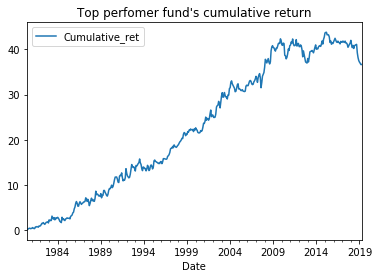

In [11]:
filtered_df.loc[filtered_df['Fund_ID']== Top_ITD_performer_by_cumulative_ROR['Fund_ID'].values[0], ['Date','Cumulative_ret']].plot( x='Date', y='Cumulative_ret', title = 'Top perfomer fund\'s cumulative return')

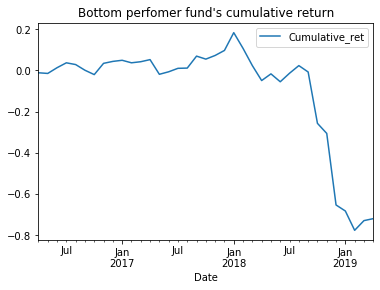

In [12]:
filtered_df.loc[filtered_df['Fund_ID']== Bottom_ITD_performer_by_cumulative_ROR['Fund_ID'].values[0], ['Date','Cumulative_ret']].plot( x='Date', y='Cumulative_ret', title = 'Bottom perfomer fund\'s cumulative return')

#### By Annualized ROR (Minimum 12 months of Data)

In [14]:
# Filter the data with fund that has minimum 12 months of data
df =DF_HF_ROR['Fund_ID'].value_counts()
funds_with_minimum_36_months = df[df >= 12].index
f_df = DF_HF_ROR[DF_HF_ROR['Fund_ID'].isin(funds_with_minimum_36_months)]
f_df.shape

(725118, 4)

In [15]:
# Sort data by Fund_ID and Date
f_df = f_df.sort_values(by=['Fund_ID','Date'])
# calculate the cumulative ROR
f_df['Interest_factor'] = (f_df['Performance']/100 +1)
f_df['Cumulative_ret (ITD)'] = f_df.groupby(['Fund_ID']).Interest_factor.cumprod() -1

In [16]:
# create dataframe with ITD cumulative ror for each funds 
Cumulative_ret_df = f_df.loc[f_df.groupby('Fund_ID').Date.idxmax(), ['Fund_ID','Date', 'Cumulative_ret (ITD)']]
Cumulative_ret_df.sort_values(by=['Fund_ID'], inplace=True)

In [17]:
# Set Fund_ID as a index for cumulative df, it will be easy to slice and concat dataframe
Cumulative_ret_df.set_index('Fund_ID' , inplace = True)

In [18]:
# create datafram with number of periods of each fund and set fund_id as index
number_of_periods = f_df.groupby('Fund_ID').agg({'Fund_ID': 'size'}).rename(columns={'Fund_ID': 'Number_of_Periods'})


In [19]:
# create Annualized dataframe
Annualized_df = pd.concat([Cumulative_ret_df,number_of_periods] , axis =1)

In [20]:
# create ITD annualized ROR for funds (Minimum 12 months data)
Annualized_df['Annualized ROR (ITD)'] = ((1+ Annualized_df['Cumulative_ret (ITD)'])**(12/Annualized_df['Number_of_Periods']))-1

In [21]:
#print The result to console
Top_ITD_performer_by_Annualized_ROR = Annualized_df.sort_values('Annualized ROR (ITD)', ascending=False).head(1)
print(f'Top ITD Performer by Annualized ROR is:\n')
print(f"Fund ID : {Top_ITD_performer_by_Annualized_ROR.index.values}")
print(f"Annualized ROR : {'{:.2%}'.format(Top_ITD_performer_by_Annualized_ROR['Annualized ROR (ITD)'].values[0])}\n")
Bottom_ITD_performer_by_Annualized_ROR = Annualized_df.sort_values('Annualized ROR (ITD)', ascending=False).tail(1)
print(f'Bottom ITD Performer by Annualized ROR is:\n')
print(f"Fund ID : {Bottom_ITD_performer_by_Annualized_ROR.index.values}")
print(f"Annualized ROR : {'{:.2%}'.format(Bottom_ITD_performer_by_Annualized_ROR['Annualized ROR (ITD)'].values[0])}\n")

Top ITD Performer by Annualized ROR is:

Fund ID : [179460]
Annualized ROR : 84.67%

Bottom ITD Performer by Annualized ROR is:

Fund ID : [169860]
Annualized ROR : -33.77%



### What are the top and bottom 10 YTD performers by ROR of 2018?

In [22]:
# filtered dataframe for year 2018
filtered_df = DF_HF_ROR[DF_HF_ROR['Date'].dt.year == 2018].copy()

In [23]:
filtered_df['Interest_factor'] = (filtered_df['Performance']/100 + 1)

In [24]:
# Note = With the assumption that performace given is Discrete Return
top10_2018_ytd_funds = filtered_df.groupby(["Fund_ID"]).Interest_factor.prod().nlargest(10).reset_index()

In [25]:
# Note = With the assumption that performace given is Discrete Return
Bottom10_2018_ytd_funds = filtered_df.groupby(["Fund_ID"]).Interest_factor.prod().nsmallest(10).reset_index()

In [26]:
# Add YTD ROR percentage column
top10_2018_ytd_funds['YTD_ROR'] = (top10_2018_ytd_funds['Interest_factor'] -1 )*100
Bottom10_2018_ytd_funds['YTD_ROR'] = (Bottom10_2018_ytd_funds['Interest_factor'] -1 )*100

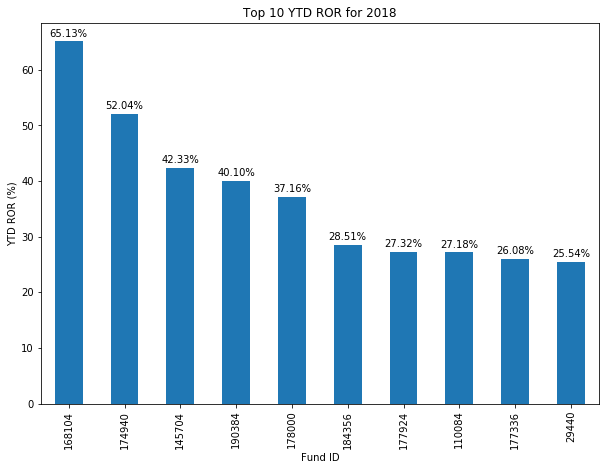

In [27]:
# Top 10 Performer for 2018 by YTD ROR
x_labels = top10_2018_ytd_funds['Fund_ID'].values
YTD_Return = top10_2018_ytd_funds['YTD_ROR']
# Plot the figure.
plt.figure(figsize=(10, 7))
ax = YTD_Return.plot(kind="bar")
ax.set_title("Top 10 YTD ROR for 2018")
ax.set_xlabel("Fund ID")
ax.set_ylabel("YTD ROR (%)")
ax.set_xticklabels(x_labels)
rects = ax.patches

# Make PCT value as labels.
labels = pd.Series(["{0:.2f}%".format(val) for val in top10_2018_ytd_funds['YTD_ROR']], index = top10_2018_ytd_funds.index)

# add lables to graph
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height +0.5 , label, ha="center", va="bottom"
    )

plt.show()

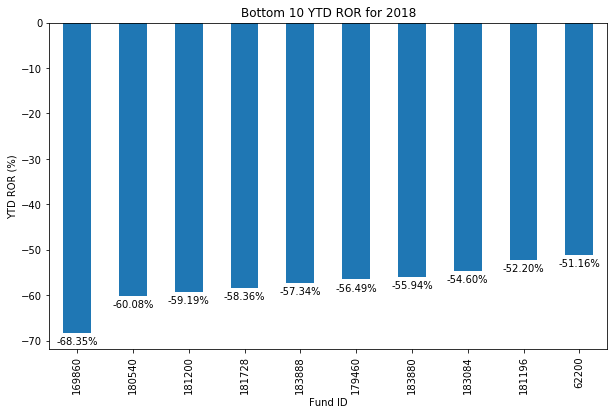

In [28]:
# Bottom 10 Performer for 2018 by YTD ROR
x_labels = Bottom10_2018_ytd_funds['Fund_ID'].values
YTD_Return = Bottom10_2018_ytd_funds['YTD_ROR']
# Plot the figure.
plt.figure(figsize=(10, 6))
ax = YTD_Return.plot(kind="bar")
ax.set_title("Bottom 10 YTD ROR for 2018")
ax.set_xlabel("Fund ID")
ax.set_ylabel("YTD ROR (%)")
ax.set_xticklabels(x_labels)

rects = ax.patches

# Make PCT value as labels
labels = pd.Series(["{0:.2f}%".format(val) for val in Bottom10_2018_ytd_funds['YTD_ROR']], index = Bottom10_2018_ytd_funds.index)


# add lables to graph
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height - 3, label, ha="center", va="bottom"
    )

plt.show()


### Assuming an annualized risk free return of 2%, which funds show the best risk adjusted returns (minimum 36 months of data)?

In [29]:
# Filter the data with fund that has minimum 36 months of data
df =DF_HF_ROR['Fund_ID'].value_counts()
funds_with_minimum_36_months = df[df >= 36].index
f_df = DF_HF_ROR[DF_HF_ROR['Fund_ID'].isin(funds_with_minimum_36_months)]

In [30]:
# Find the annualized return of funds (Minimum 36 months of data)

# Sort data by Fund_ID and Date
f_df = f_df.sort_values(by=['Fund_ID','Date'])
# calculate the cumulative ROR
f_df['Interest_factor'] = (f_df['Performance']/100 +1)
f_df['Cumulative_ret (ITD)'] = f_df.groupby(['Fund_ID']).Interest_factor.cumprod()-1
# create dataframe with ITD cumulative ror for each funds 
Cumulative_ret_df = f_df.loc[f_df.groupby('Fund_ID').Date.idxmax(), ['Fund_ID','Date', 'Cumulative_ret (ITD)']]
Cumulative_ret_df.sort_values(by=['Fund_ID'], inplace=True)
# Set Fund_ID as a index for cumulative df, it will be easy to slice and concat datafram
Cumulative_ret_df.set_index('Fund_ID' , inplace = True)
# create datafram with number of periods of each fund and set fund_id as index
number_of_periods = f_df.groupby('Fund_ID').agg({'Fund_ID': 'size'}).rename(columns={'Fund_ID': 'Number_of_Periods'})
# create Annualized dataframe
Annualized_df = pd.concat([Cumulative_ret_df,number_of_periods] , axis =1)
# create ITD annualized ROR for funds (Minimum 12 months data)
Annualized_df['Annualized ROR (ITD)'] = ((1+ Annualized_df['Cumulative_ret (ITD)'])**(12/Annualized_df['Number_of_Periods']))-1

In [31]:
# Find the annualized Standrd Deviation of funds (Minimum 36 months of data)

Annualized_STD = f_df.groupby('Fund_ID').agg({'Interest_factor': 'std'}).rename(columns={'Interest_factor': 'Standard deviation'})
Annualized_STD['Annualized Standard deviation'] = Annualized_STD['Standard deviation'] * np.sqrt(12)

In [32]:
f_df[f_df['Fund_ID']== 185684]

,Fund_ID,Date,Performance,NAV,Interest_factor,Cumulative_ret (ITD)
588559,185684,2015-08-31,0.42500,NaN,1.004250,0.004250
586045,185684,2015-09-30,0.43000,NaN,1.004300,0.008568
588692,185684,2015-10-31,0.42000,NaN,1.004200,0.012804
586046,185684,2015-11-30,0.42500,NaN,1.004250,0.017109
588623,185684,2015-12-31,0.41000,NaN,1.004100,0.021279
585233,185684,2016-01-31,0.39500,NaN,1.003950,0.025313
588674,185684,2016-02-29,0.39500,NaN,1.003950,0.029363
588465,185684,2016-03-31,0.40000,NaN,1.004000,0.033480
588904,185684,2016-04-30,0.40000,NaN,1.004000,0.037614
622843,185684,2016-05-31,0.39500,NaN,1.003950,0.041713


In [33]:
# Annualized risk free return rate is 2%
Annualized_Risk_Free_ROR = 2/100

In [34]:
# calculate Annualized risk adjusted return
Annualized_df = pd.concat([Annualized_df,Annualized_STD] , axis =1 )
Annualized_df['Risk_Adjusted_return(Sharp Ratio)'] = (Annualized_df['Annualized ROR (ITD)'] - Annualized_Risk_Free_ROR)/Annualized_df['Annualized Standard deviation']

In [35]:
# Sort the datafram by Risk_Adjusted_return(Sharp Ratio) in descending order
Annualized_df.sort_values('Risk_Adjusted_return(Sharp Ratio)',ascending=False,inplace = True)

In [36]:
# Best risk adjusted return fund
Best_Fund_By_RAR = Annualized_df.head(1)
print(f'Best Fund by Annualized Risk Adjusted Return (Sharp Ratio) is:\n')
print(f"Fund ID : {Best_Fund_By_RAR.index.values}")
print(f"Annualized Risk Adjusted Return (Sharp Ratio) : {Best_Fund_By_RAR['Risk_Adjusted_return(Sharp Ratio)'].values[0]}")
print(f"Annualized Standard Deviation (volatility) : {Best_Fund_By_RAR['Annualized Standard deviation'].values[0]}")
print(f"Annualized ROR : {'{:.2%}'.format(Best_Fund_By_RAR['Annualized ROR (ITD)'].values[0])}")
print(f"Number of Months : {Best_Fund_By_RAR['Number_of_Periods'].values[0]}")
print(f"Cumulative ROR : {'{:.2%}'.format(Best_Fund_By_RAR['Cumulative_ret (ITD)'].values[0])}\n")

Best Fund by Annualized Risk Adjusted Return (Sharp Ratio) is:

Fund ID : [185684]
Annualized Risk Adjusted Return (Sharp Ratio) : 77.42565177848907
Annualized Standard Deviation (volatility) : 0.000369466118371358
Annualized ROR : 4.86%
Number of Months : 43
Cumulative ROR : 18.54%



#### Create a composite index of the best performing 10 funds over 2018 and track the performance over the year.
- Assume the portfolio is reweighted at the beginning of each month based on the prior month’s top performers
- Assume equal weighting each month (each fund is 10% of the portfolio)
- What would be the expected rate of return at the end of 2018?
- Which fund contributed the most to the composite’s total rate of return? What its contribution to the total contribution of the pro-forma index?

In [37]:
# filter the data
filtered_df = DF_HF_ROR[(DF_HF_ROR['Date'] >= '12/31/2017') & (DF_HF_ROR['Date'] <= '12/31/2018')].copy()
filtered_df = filtered_df.sort_values(['Fund_ID', 'Date'])

In [38]:
# Return Previous months performace 
filtered_df['Previous_month_performance'] = filtered_df.groupby(['Fund_ID']).Performance.shift(1)

# Drop null values from previous month performance column: 
#This will drop all the rows for December 2017 and only keep rows for 2018
filtered_df = filtered_df[filtered_df['Previous_month_performance'].notna()]

In [39]:
# Create Composite index
# -- This will return top 10 best performing funds based on previous month performance for each month
# -- Using MultipleIndex to store Fund_ID, Date, and current month performance 
Composite_Index = filtered_df.set_index(['Fund_ID' , 'Date', 'Performance']).groupby('Date').Previous_month_performance.nlargest(10)
Composite_Index = Composite_Index.reset_index(level=[0,1,1])
Composite_Index['Performance'] = Composite_Index.index
Composite_Index['Performance_decimal'] = Composite_Index['Performance']/100

Composite_Index.reset_index(drop = True , inplace = True)

In [40]:
# Add Weights column : in our case we have equal weight of 10%
Composite_Index['Weight_PCT'] = 0.10

# Calculate the weighted return
Composite_Index['Weighted_Performance_decimal'] = (Composite_Index['Performance_decimal']) * Composite_Index['Weight_PCT']
Composite_Index

,Date,Fund_ID,Previous_month_performance,Performance,Performance_decimal,Weight_PCT,Weighted_Performance_decimal
0,2018-01-31,181196,117.02220,2.36000,0.023600,0.1,0.002360
1,2018-01-31,179264,95.90460,-2.34525,-0.023453,0.1,-0.002345
2,2018-01-31,179164,88.74000,-1.38500,-0.013850,0.1,-0.001385
3,2018-01-31,179460,67.30500,-9.29500,-0.092950,0.1,-0.009295
4,2018-01-31,181200,58.54740,-4.60000,-0.046000,0.1,-0.004600
5,2018-01-31,181728,56.30000,-5.05000,-0.050500,0.1,-0.005050
6,2018-01-31,183084,49.27500,-0.90500,-0.009050,0.1,-0.000905
7,2018-01-31,179936,39.16185,-2.27295,-0.022729,0.1,-0.002273
8,2018-01-31,180924,38.50000,-2.02000,-0.020200,0.1,-0.002020
9,2018-01-31,179940,37.63495,-2.10155,-0.021015,0.1,-0.002102


In [41]:
# Return Monthly performance of composite index based on weighted return of the funds
Composite_Index_monthly_perfomance = Composite_Index.groupby('Date').Weighted_Performance_decimal.sum().reset_index()

# Expected Rate of return at the end of 2018 for composite index
Expected_ROR_2018 = (Composite_Index_monthly_perfomance.sum()/12)
print(f"Expected (Average) ROR at the end of 2018 for the composite fund is: {'{:.2%}'.format(Expected_ROR_2018.values[0])}")

Expected (Average) ROR at the end of 2018 for the composite fund is: -3.87%


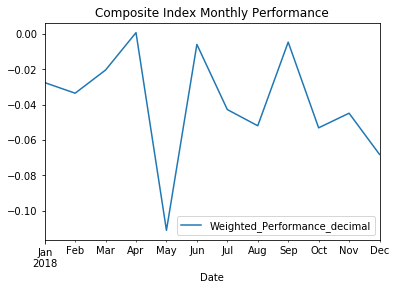

In [42]:
# Composite Index Monthly Performance
Composite_Index_monthly_perfomance.plot.line(x = 'Date' , y ='Weighted_Performance_decimal', title = 'Composite Index Monthly Performance')



In [43]:
Composite_Index_monthly_perfomance

,Date,Weighted_Performance_decimal
0,2018-01-31,-0.027615
1,2018-02-28,-0.033591
2,2018-03-31,-0.020519
3,2018-04-30,0.000556
4,2018-05-31,-0.110918
5,2018-06-30,-0.006073
6,2018-07-31,-0.042825
7,2018-08-31,-0.051958
8,2018-09-30,-0.004784
9,2018-10-31,-0.053121


In [44]:
# Total ROR at the end of 2018
Composite_Index_monthly_perfomance['Interest_factor'] = Composite_Index_monthly_perfomance['Weighted_Performance_decimal']+1
Total_ROR_at_the_end_2018 = (Composite_Index_monthly_perfomance.Interest_factor.prod()-1)*100
print (f'Total ROR at the end of 2018 for the composite index is : {"{0:.2f}%".format(Total_ROR_at_the_end_2018)}')

#fund contributed the most to the composite’s total rate of return

Composite_Index['Interest_factor'] = Composite_Index['Weighted_Performance_decimal'] + 1

Fund_Contribution  = Composite_Index.groupby('Fund_ID').Interest_factor.prod()
Fund_Contribution = Fund_Contribution.reset_index()
Fund_Contribution = Fund_Contribution.sort_values('Interest_factor', ascending = False)
Fund_Contribution.reset_index(drop = True, inplace =True)
Fund_Contribution

Fund_Contributted_the_most = Fund_Contribution.head(1)
print(f'The fund contributed the most to Composite total ROR is:')
print(f"Fund ID : {Fund_Contributted_the_most['Fund_ID'].values[0]}")

# (Fund_Contribution['Interest_factor'].div(Total_ROR_at_the_en//////////d_2018)


Total ROR at the end of 2018 for the composite index is : -38.06%
The fund contributed the most to Composite total ROR is:
Fund ID : 184848


#### Provide the Top/Bottom 10 increases in AUM since the beginning of 2018 

In [45]:
# filteretd the dataframe to get data since beging of 2018
# Assets provided millions.

filtered_df = DF_HF_ASSETS[DF_HF_ASSETS['Date'] >= '2017-12-31'].copy()

In [46]:
#sort the datafram in ascending order
filtered_df.sort_values('Date' , ascending = True, inplace = True)

# Calculate AMU increses since the beging of 2018
Grouped_data=filtered_df.groupby(by='Fund_ID').agg(['first','last'])
Grouped_data.columns =  ['Starting Date (End of 2017)', 'Latest Date', 'AUM at start of 2018 (Millions)', 'Latest AUM (Millions)']
Grouped_data['AUM Increase (Millions)'] =  Grouped_data['Latest AUM (Millions)'] - Grouped_data['AUM at start of 2018 (Millions)']

# Order the datafram by AUM Increases in Descending order and return top and bottom 10 funds
Grouped_data.sort_values('AUM Increase (Millions)', ascending = False, inplace = True )
Top10_AUM_Increased_since_2018 = Grouped_data.head(10)
Bottom10_AUM_Increased_since_2018 = Grouped_data.tail(10)

In [47]:
# Top 10 increase since the beging of 2018
Top10_AUM_Increased_since_2018

,Starting Date (End of 2017),Latest Date,AUM at start of 2018 (Millions),Latest AUM (Millions),AUM Increase (Millions)
Fund_ID,,,,,
72692,2017-12-31,2019-04-30,10908.000,15267.00,4359.000
27164,2017-12-31,2019-05-31,38186.500,42282.50,4096.000
169580,2017-12-31,2019-04-30,2149.000,4682.50,2533.500
185052,2017-12-31,2019-04-30,1776.500,4041.50,2265.000
149652,2017-12-31,2019-04-30,2407.210,3843.59,1436.380
147824,2017-12-31,2019-04-30,454.000,1742.00,1288.000
175040,2017-12-31,2019-04-30,2227.045,3368.20,1141.155
28304,2017-12-31,2019-04-30,9858.500,10803.00,944.500
76272,2017-12-31,2019-04-30,901.000,1842.00,941.000


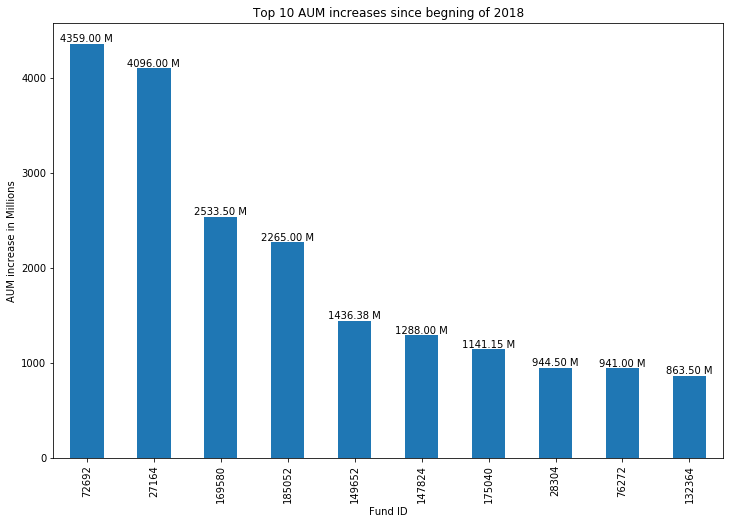

In [48]:
x_labels = Top10_AUM_Increased_since_2018.index.values
YTD_Return = Top10_AUM_Increased_since_2018['AUM Increase (Millions)']
# Plot the figure.
plt.figure(figsize=(12, 8))
ax = YTD_Return.plot(kind="bar")
ax.set_title("Top 10 AUM increases since begning of 2018")
ax.set_xlabel("Fund ID")
ax.set_ylabel("AUM increase in Millions")
ax.set_xticklabels(x_labels)
rects = ax.patches

# Make PCT value as labels.
labels = pd.Series(["{0:.2f} M".format(val) for val in Top10_AUM_Increased_since_2018['AUM Increase (Millions)']], index = Top10_AUM_Increased_since_2018.index)

# add lables to graph
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 1.5 , label, ha="center", va="bottom"
    )

plt.show()

In [49]:
# Bottom 10 increase since the beging of 2018
Bottom10_AUM_Increased_since_2018

,Starting Date (End of 2017),Latest Date,AUM at start of 2018 (Millions),Latest AUM (Millions),AUM Increase (Millions)
Fund_ID,,,,,
164336,2017-12-31,2019-04-30,6627.500,2843.00,-3784.500
181088,2017-12-31,2019-04-30,4195.500,173.50,-4022.000
176736,2017-12-31,2019-04-30,11084.460,6698.37,-4386.090
101884,2017-12-31,2019-04-30,9963.085,5324.22,-4638.865
161448,2017-12-31,2019-05-31,8000.000,2900.00,-5100.000
126868,2017-12-31,2019-05-31,14516.100,6902.75,-7613.350
101940,2017-12-31,2019-04-30,12354.525,4336.79,-8017.735
173512,2017-12-31,2019-04-30,24994.105,15366.02,-9628.085
121292,2017-12-31,2019-03-31,22356.000,8712.28,-13643.720


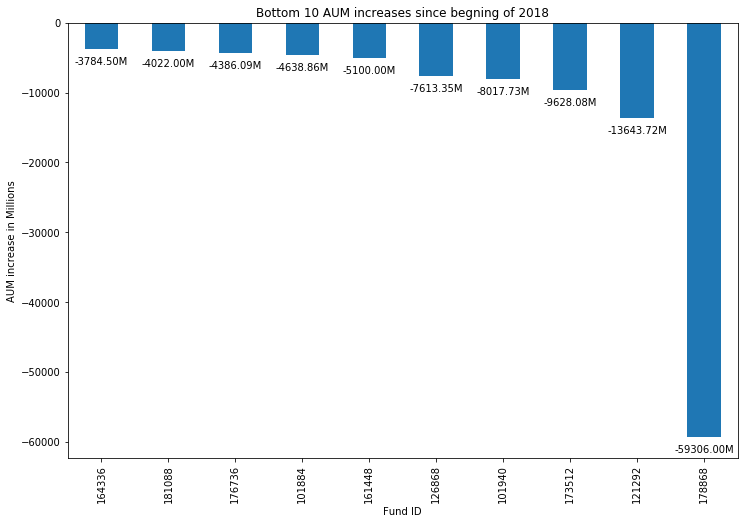

In [50]:
x_labels = Bottom10_AUM_Increased_since_2018.index.values
YTD_Return = Bottom10_AUM_Increased_since_2018['AUM Increase (Millions)']
plt.figure(figsize=(12, 8))
ax = YTD_Return.plot(kind="bar")
ax.set_title("Bottom 10 AUM increases since begning of 2018")
ax.set_xlabel("Fund ID")
ax.set_ylabel("AUM increase in Millions")
ax.set_xticklabels(x_labels)

rects = ax.patches

# Make PCT value as labels
labels = pd.Series(["{0:.2f}M".format(val) for val in Bottom10_AUM_Increased_since_2018['AUM Increase (Millions)']], index = Bottom10_AUM_Increased_since_2018.index)


# add lables to graph
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height - 2500, label,ha="center", va="bottom"
    )

plt.show()

##### Why AUM Tracking is Important ?

##### AUM refers to the total market value of assets being managed by fund manager or institution. the exact definition of AUM varies by institution; some include bank deposits, mutual funds, and cash in their computation, while others only consider the funds that investors have given an advisor to trade on their behalf.

##### AUM reflects management performance and size. Oftenly, a fund's management fees and expenses are calculated as a percentage of AUM. So, it is imperative to track AUM increases. Many firm will monitor AUM as it relates to determining the strength of the company. Investment companies also use AUM as a marketing tool to attract new investors. AUM can help investors get an indication of the size of a company's operations relative to its competitors. 

#### Segment managers into appropriate buckets by AUM size and evaluate performance (ROR) across the segments. What results and general trends do you see?

In [51]:
# return latest AUM of the Funds
latest_fund_AUM = DF_HF_ASSETS.sort_values(['Fund_ID','Date']).groupby('Fund_ID').last()

In [52]:
# Order Funds by AUM by descending order
latest_fund_AUM.sort_values('Assets', ascending = False, inplace = True)

In [53]:
# Segment Funds based on AUM
bins = [0,100,200,300,400,500,600,700,800,900,1000,90000]
labels = ["AUM Under 100 Millions","AUM Between 100 to 200 Millions","AUM Between 200 to 300 Millions","AUM Between 300 to 400 Millions","AUM Between 400 to 500 Millions","AUM Between 500 to 600 Millions","AUM Between 600 to 700 Millions", "AUM Between 700 to 800 Millions", "AUM Between 800 to 900 Millions","AUM Between 900 to 1000 Millions","AUM Over 1000 Millions"]

latest_fund_AUM['Segments'] = pd.cut(latest_fund_AUM['Assets'],bins=bins, labels=labels , include_lowest=True)

##### AUM can change beacuse of two reasons 1) Price changes 2) New investments
##### I could have calculated performance from assets data but to do so i need to assume that chnages in AUM is only beacase of price chnage and there is no new investments, which is not realistic assumption so decided to use ROR data (Cumulative ROR of the funds) for performance evaluation.  
##### Assets dataframe has less funds then ROR dataframe so using left outer join (Left table is AUM Data) to return all the funds from Assets dataframe and only the matched funds from ROR dataframe

In [54]:
# Calculate the cumulative ROR of Funds 
f_df = DF_HF_ROR.copy()
# Sort data by Fund_ID and Date
f_df = f_df.sort_values(by=['Fund_ID','Date'])
# calculate the cumulative ROR
f_df['Interest_factor'] = (f_df['Performance']/100 +1)
f_df['Cumulative_ret (ITD)'] = f_df.groupby(['Fund_ID']).Interest_factor.cumprod()-1
# create dataframe with ITD cumulative ROR for each funds 
Cumulative_ret_df = f_df.loc[f_df.groupby('Fund_ID').Date.idxmax(), ['Fund_ID','Date', 'Cumulative_ret (ITD)']]
Cumulative_ret_df.sort_values(by=['Fund_ID'], inplace=True)
# Set Fund_ID as a index for cumulative df, it will be easy to slice and concat datafram
Cumulative_ret_df.set_index('Fund_ID' , inplace = True)

In [55]:
# update column to indetify data is coming from ROR dataframe
Cumulative_ret_df.columns =['ROR_Date', 'Cumulative_ROR (ITD)']

In [56]:
# create combine datafram of AUM dataframe and cumulative ROR dataframe to compare perfomance across segements
Combine_Df = latest_fund_AUM.join(Cumulative_ret_df , how="left")

##### Segment Analysis
 - Segment Size Distribution
 - Performance Accrose Segemnts

AUM Under 100 Millions              0.716209
AUM Between 100 to 200 Millions     0.104350
AUM Between 200 to 300 Millions     0.052563
AUM Over 1000 Millions              0.041429
AUM Between 300 to 400 Millions     0.027965
AUM Between 400 to 500 Millions     0.017090
AUM Between 500 to 600 Millions     0.013206
AUM Between 600 to 700 Millions     0.009839
AUM Between 800 to 900 Millions     0.006473
AUM Between 900 to 1000 Millions    0.006214
AUM Between 700 to 800 Millions     0.004661
Name: Segments, dtype: float64

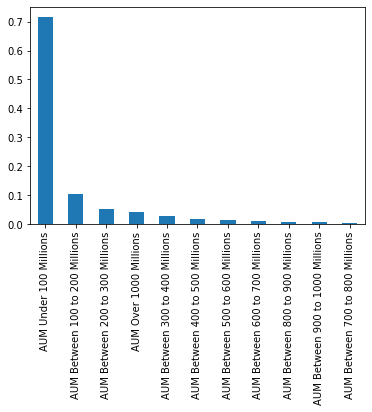

In [57]:
# Segment Size Distribution 
Combine_Df['Segments'].value_counts(normalize =True).plot( kind = 'bar')
Combine_Df['Segments'].value_counts(normalize = True)


In [58]:
Segments_average_cumulative_ROR = Combine_Df.groupby('Segments')['Cumulative_ROR (ITD)'].mean()
print("Segment's average cumulative ROR : ")
print(Segments_average_cumulative_ROR)
print("=================================================")
Segments_volatility = Combine_Df.groupby('Segments')['Cumulative_ROR (ITD)'].std()
print("Segment's volatility: Standard Deviation")
print(Segments_volatility)

Segment's average cumulative ROR : 
Segments
AUM Under 100 Millions              0.550503
AUM Between 100 to 200 Millions     0.871730
AUM Between 200 to 300 Millions     0.832223
AUM Between 300 to 400 Millions     1.076742
AUM Between 400 to 500 Millions     0.841290
AUM Between 500 to 600 Millions     1.135824
AUM Between 600 to 700 Millions     0.898352
AUM Between 700 to 800 Millions     1.212667
AUM Between 800 to 900 Millions     0.652552
AUM Between 900 to 1000 Millions    1.597225
AUM Over 1000 Millions              1.256225
Name: Cumulative_ROR (ITD), dtype: float64
Segment's volatility: Standard Deviation
Segments
AUM Under 100 Millions              1.189983
AUM Between 100 to 200 Millions     1.583421
AUM Between 200 to 300 Millions     1.039569
AUM Between 300 to 400 Millions     3.554661
AUM Between 400 to 500 Millions     1.025124
AUM Between 500 to 600 Millions     2.564555
AUM Between 600 to 700 Millions     1.259100
AUM Between 700 to 800 Millions     1.836838
AUM Bet

#### Segment Observation:

##### Distribution:
  * Segment size is very right skewd as majority of funds has AUM under 100 millions (71% of funds)

##### Performance across segments:
  * AUM between 800 to 900 millions segment has lowest volatility which suggests that their fund managers tend to take less risk. This Segment also has second lowest average cumulative ROR.
  
  * AUM between 900 to 1000 millions and AUM over 1000 Millions has highest and second highest average cumulative ROR but their fund managers has taken highest and second highest risk respectively.
  
  * AUM Under 100 Millions has the lowest average cumulative ROR and their fund manager has taken medium risk.
  
  * Based on above mentioned observations, we can say that Higher AUM funds managers has taken higher risk and scored higher average cumulative ROR while lower AUM funds managers taken medium to low risk and return comparativly lower average cumulative ROR.
  
  * Since segment size is very right skewed, this observations are not stongly significant. it would have been more significant if segment size distribution was approximately uniform.